In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import PIL
import time
from tqdm.notebook import tqdm
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

In [ ]:
# loading the dataset
(x_train,y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0],28,28,1).astype('float32')
x_train = (x_train-127.5)/127.5
x_test = (x_test-127.5)/127.5
y_train= y_train.T
y_test=y_test.T

11490434/11490434 [==============================] - 2s 0us/step


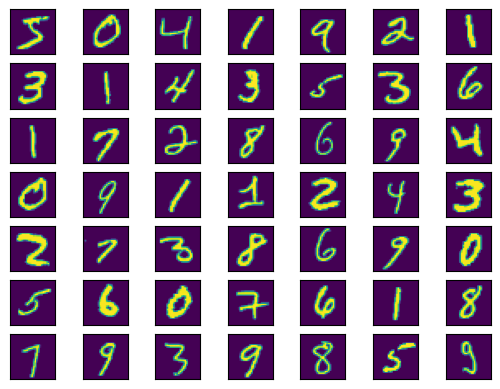

In [ ]:
# printing the dataset
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(x_train[i])
plt.show()

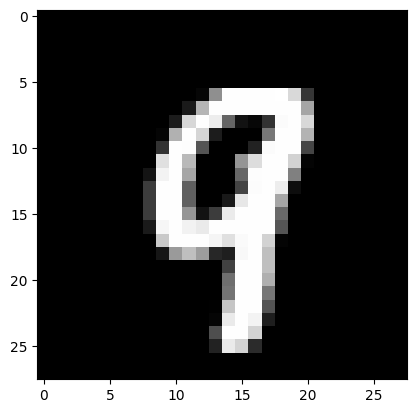

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [ ]:
# checking shape of train and test
index = 800
plt.imshow(x_train[index],cmap='gray')
plt.show()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [ ]:
# creating the generator using CNN layers
num =100
weight_init = keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
channels = 1
def Generator():
  model= tf.keras.models.Sequential([
      # 1d array for random noise
      tfl.Dense(7*7*256, use_bias='False',input_shape=[num]),
      tfl.BatchNormalization(),
      tfl.LeakyReLU(),

      tfl.Reshape([7, 7, 256]),

      # upsample to 14x14
      tfl.Conv2DTranspose(128, (5,5), (1,1), padding="same"),
      tfl.BatchNormalization(),
      tfl.LeakyReLU(),

      # upsample to 28x28
      tfl.Conv2DTranspose(64, (5,5), (2,2), padding="same"),
      tfl.BatchNormalization(),
      tfl.LeakyReLU(),

      tfl.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
  ])
  return model

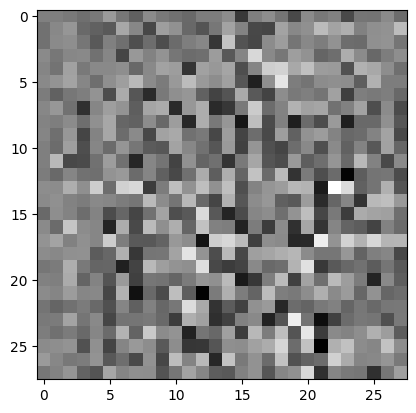

In [ ]:
#initialising the generator
generator = Generator()
noise = tf.random.normal(shape=[1, num])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0],cmap='gray')

In [ ]:
# creating the discriminator using CNN layers
def Discriminator():
    model = keras.models.Sequential([
        tfl.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
        tfl.LeakyReLU(0.2),
        tfl.Dropout(0.3),

        tfl.Conv2D(128, (5,5), (2,2), padding="same"),
        tfl.LeakyReLU(0.2),
        tfl.Dropout(0.3),

        tfl.Conv2D(256, (5,5), (1,1), padding="same"),
        tfl.LeakyReLU(0.2),
        tfl.Dropout(0.3),

        tfl.Flatten(),
        tfl.Dense(1, activation='sigmoid')
    ])
    return model


In [ ]:
# initialising the discriminator
discriminator = Discriminator()
prob = discriminator(generated_image)
print(prob)

tf.Tensor([[0.4997196]], shape=(1, 1), dtype=float32)


In [ ]:
# putting the generator and discriminator together
class DCGAN(keras.Model):
  def __init__(self,generator,discriminator, num):
    super().__init__()
    self.generator = generator
    self.discriminator = discriminator
    self.g_loss_metric = keras.metrics.Mean(name='g_loss')
    self.d_loss_metric = keras.metrics.Mean(name='d_loss')

  def metric(self):
    return [self.g_loss_metric, self.d_loss_metric]

  def compile(self, g_ooptimizer,d_optimizer,loss_fn):
    super(DCGAN,self).compile()


In [ ]:
# training the now formed DCGAN
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, num):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.num = num
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_noise = tf.random.normal(shape=(batch_size, self.num))

        # training the discriminator
        with tf.GradientTape() as tape:
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # calculating total loss by discriminator
            d_loss = (d_loss_real + d_loss_fake) / 2


        # gradient descent for discriminator
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))


        # training the generator
        labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)

            # calculating total loss by generator
            g_loss = self.loss_fn(labels, pred_fake)

        # gradient descent for generator
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [ ]:
# compiling and running it on train dataset
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        g_img = self.model.generator(self.noise)
        g_img = (g_img * 127.5) + 127.5
        #g_img.numpy()

        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            #img = array_to_img(g_img[i])
            plt.imshow(g_img[i],cmap='gray')
            plt.axis('off')
        # plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

Epoch 1/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.5188 - g_loss: 0.4221

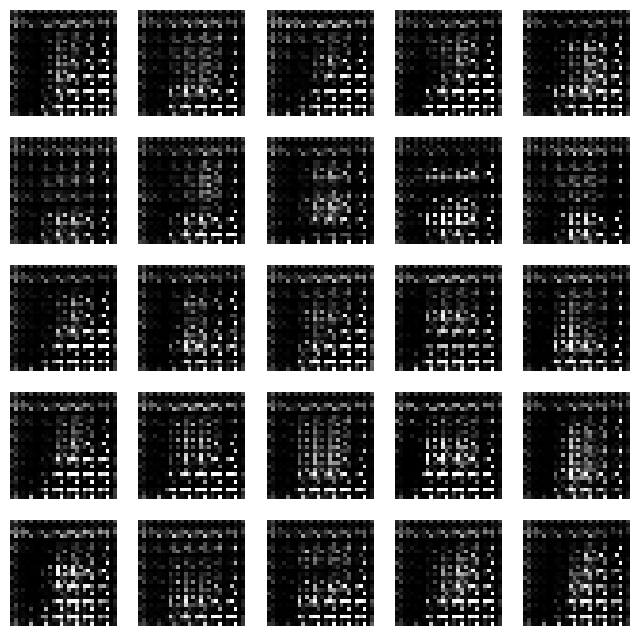

188/188 [==============================] - 9s 22ms/step - d_loss: 0.5217 - g_loss: 0.4297
Epoch 2/50
185/188 [============================>.] - ETA: 0s - d_loss: 0.3416 - g_loss: 0.2591

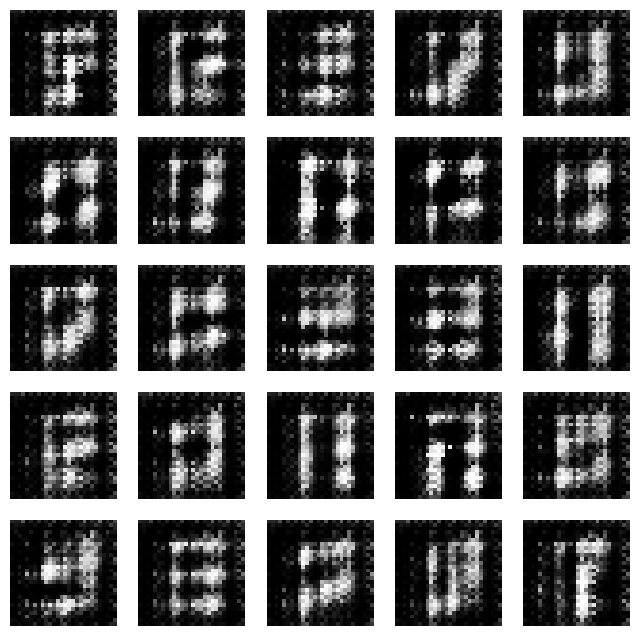

188/188 [==============================] - 4s 22ms/step - d_loss: 0.3435 - g_loss: 0.2715
Epoch 3/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6777 - g_loss: 0.6534

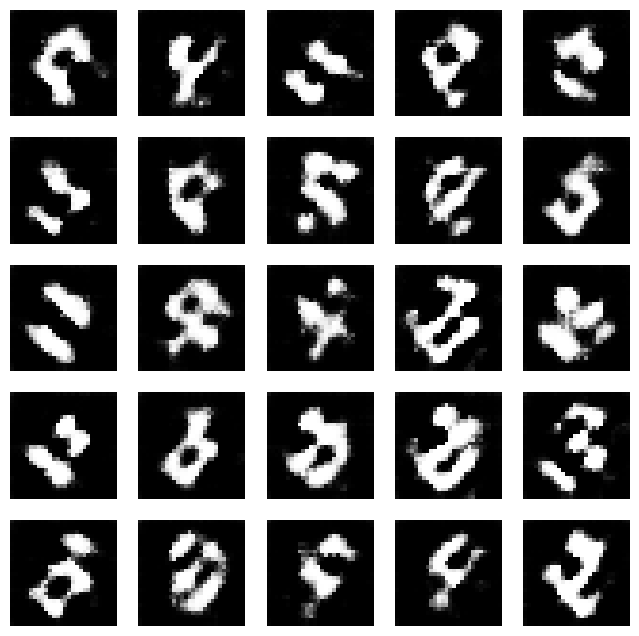

188/188 [==============================] - 4s 20ms/step - d_loss: 0.6778 - g_loss: 0.6535
Epoch 4/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.7101 - g_loss: 0.7606

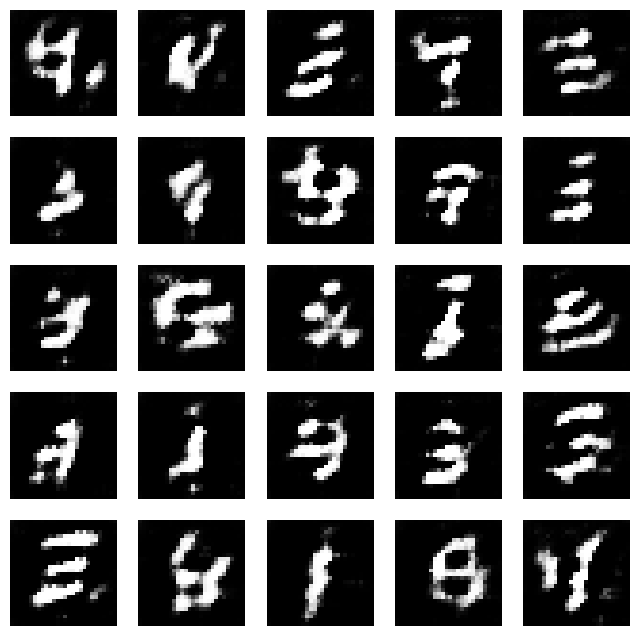

188/188 [==============================] - 4s 21ms/step - d_loss: 0.7098 - g_loss: 0.7604
Epoch 5/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6862 - g_loss: 0.7371

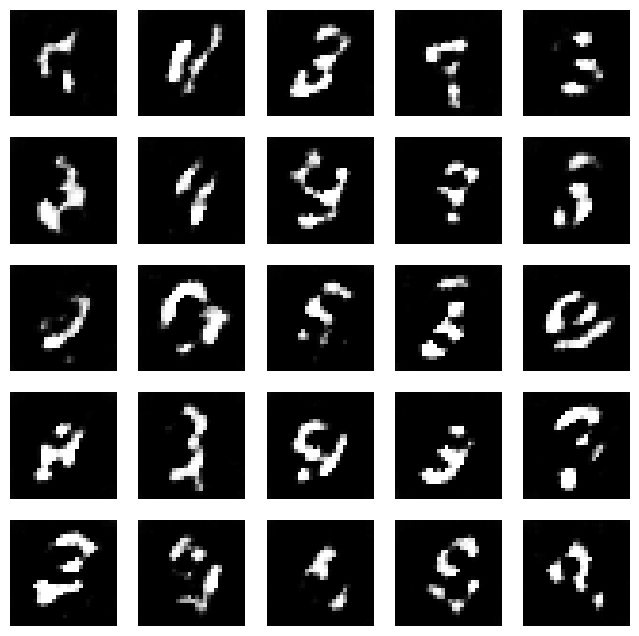

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6862 - g_loss: 0.7368
Epoch 6/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6723 - g_loss: 0.7521

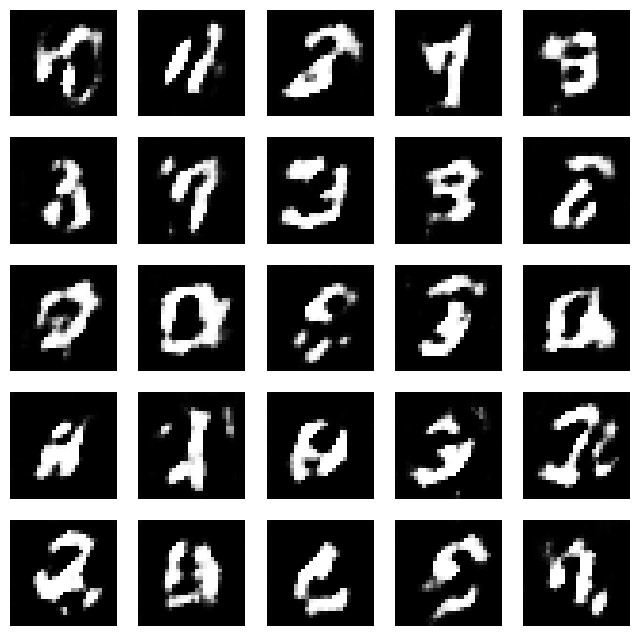

188/188 [==============================] - 4s 20ms/step - d_loss: 0.6720 - g_loss: 0.7524
Epoch 7/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6668 - g_loss: 0.7665

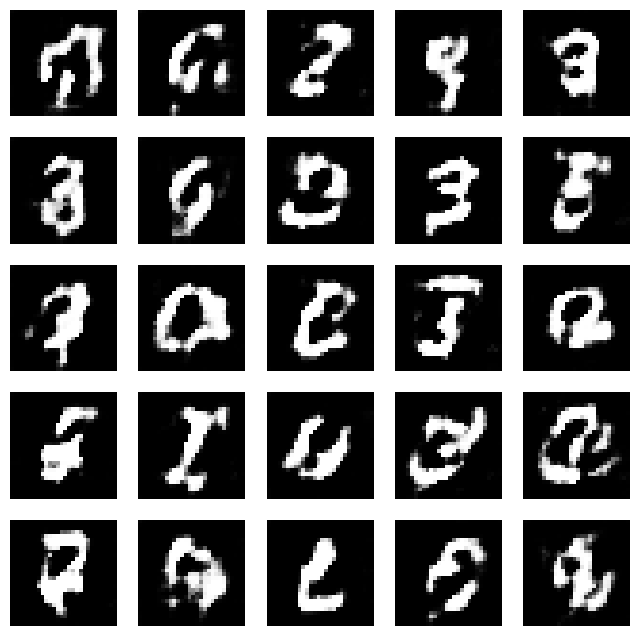

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6667 - g_loss: 0.7671
Epoch 8/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6538 - g_loss: 0.7845

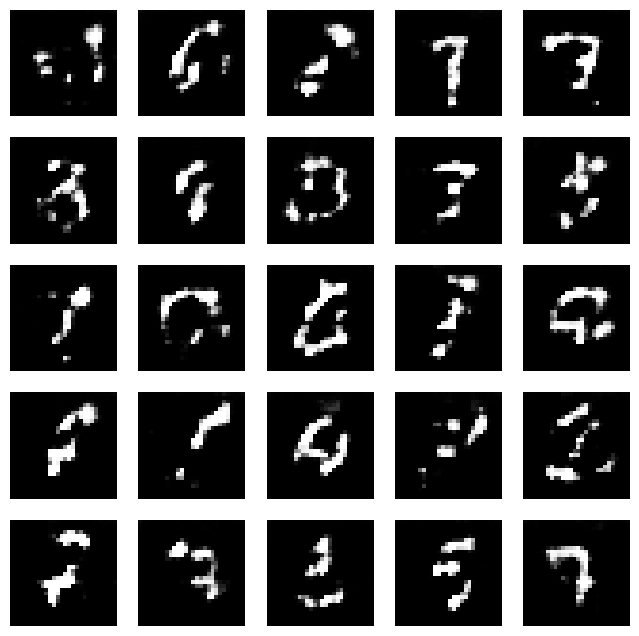

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6540 - g_loss: 0.7833
Epoch 9/50
185/188 [============================>.] - ETA: 0s - d_loss: 0.6485 - g_loss: 0.7979

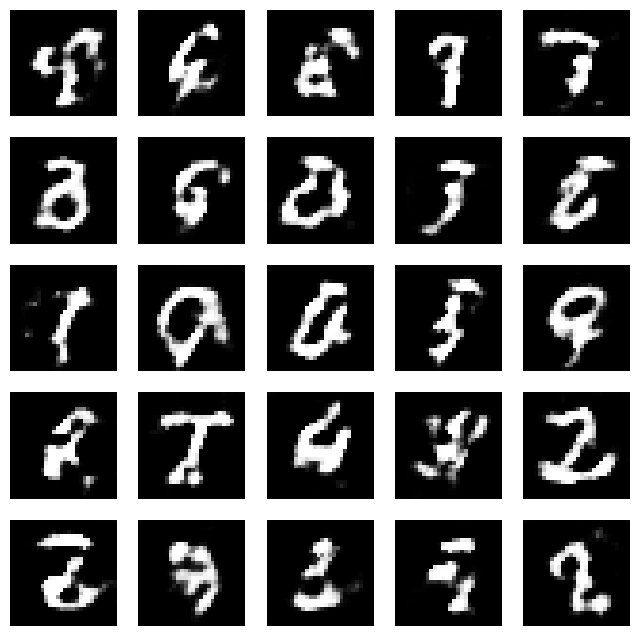

188/188 [==============================] - 4s 21ms/step - d_loss: 0.6488 - g_loss: 0.7978
Epoch 10/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6568 - g_loss: 0.7904

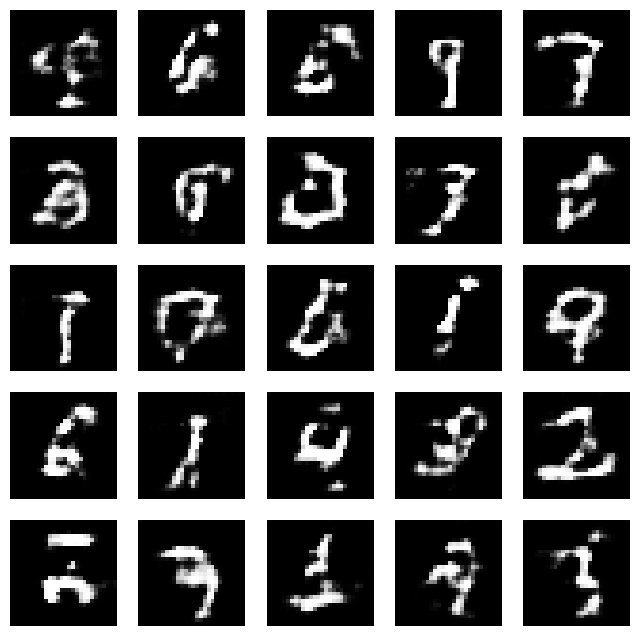

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6559 - g_loss: 0.7899
Epoch 11/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6550 - g_loss: 0.7947

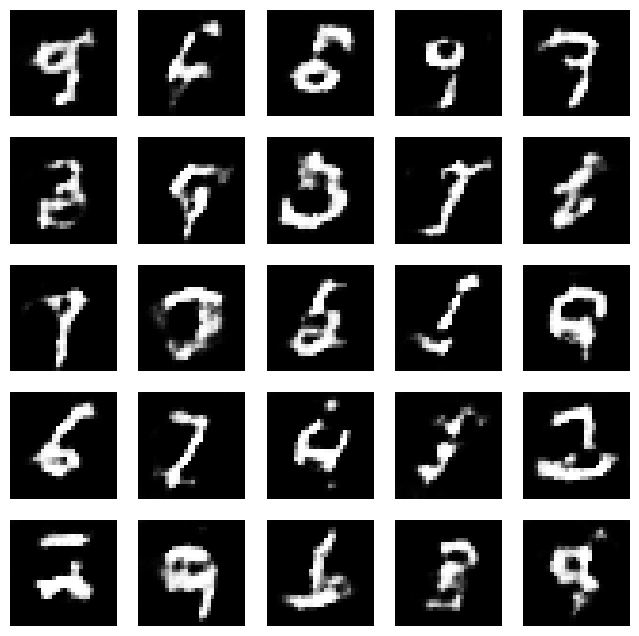

188/188 [==============================] - 4s 21ms/step - d_loss: 0.6545 - g_loss: 0.7952
Epoch 12/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6496 - g_loss: 0.7958

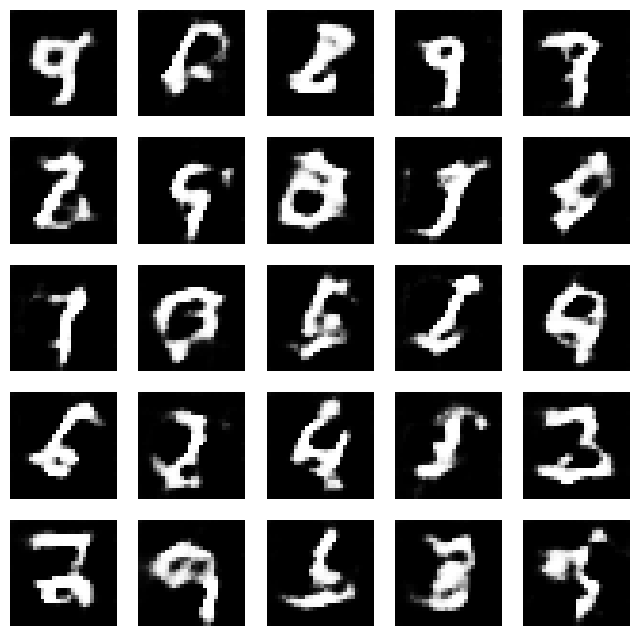

188/188 [==============================] - 5s 26ms/step - d_loss: 0.6498 - g_loss: 0.7961
Epoch 13/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6510 - g_loss: 0.8013

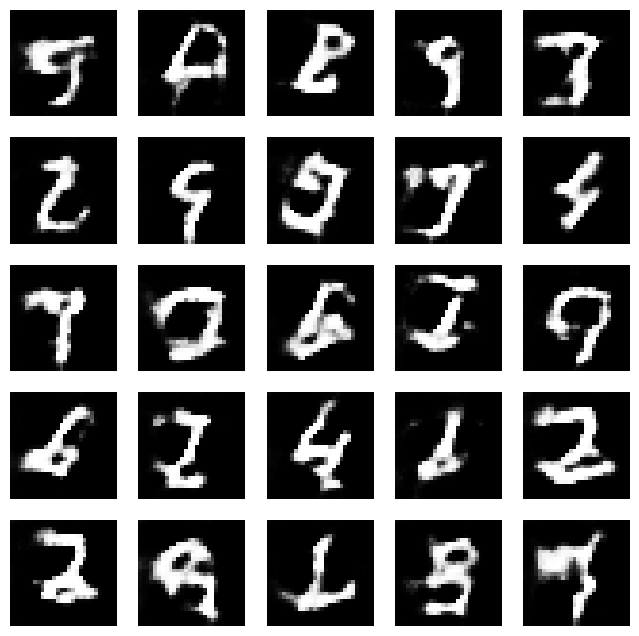

188/188 [==============================] - 5s 26ms/step - d_loss: 0.6510 - g_loss: 0.8013
Epoch 14/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6500 - g_loss: 0.7952

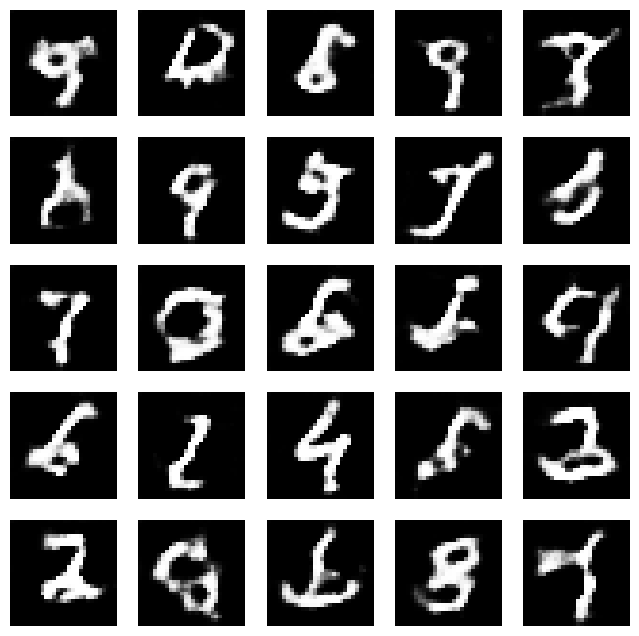

188/188 [==============================] - 4s 21ms/step - d_loss: 0.6500 - g_loss: 0.7947
Epoch 15/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6450 - g_loss: 0.7943

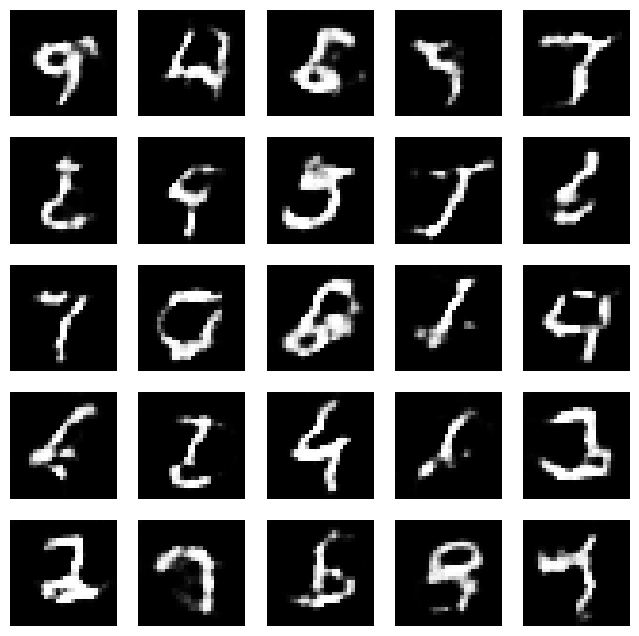

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6454 - g_loss: 0.7935
Epoch 16/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6435 - g_loss: 0.8128

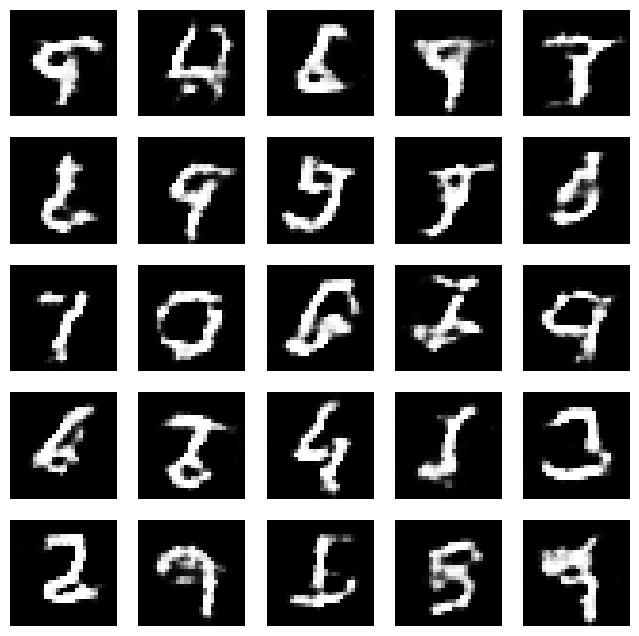

188/188 [==============================] - 4s 24ms/step - d_loss: 0.6429 - g_loss: 0.8144
Epoch 17/50
185/188 [============================>.] - ETA: 0s - d_loss: 0.6443 - g_loss: 0.8279

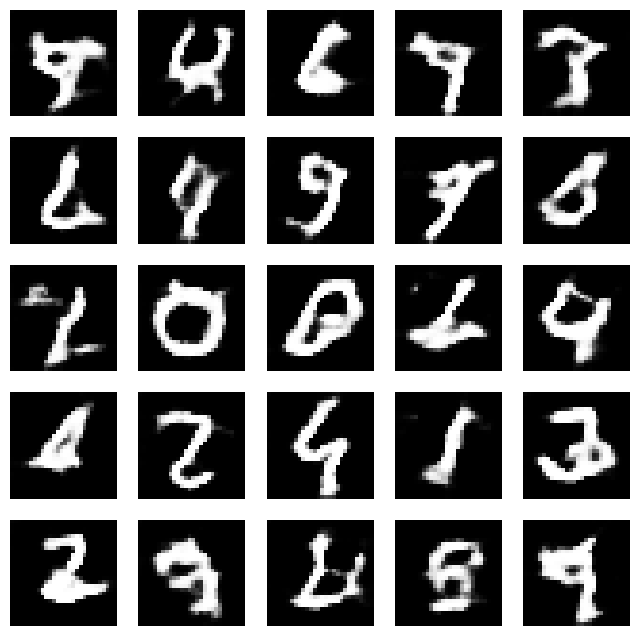

188/188 [==============================] - 4s 21ms/step - d_loss: 0.6452 - g_loss: 0.8283
Epoch 18/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6385 - g_loss: 0.8141

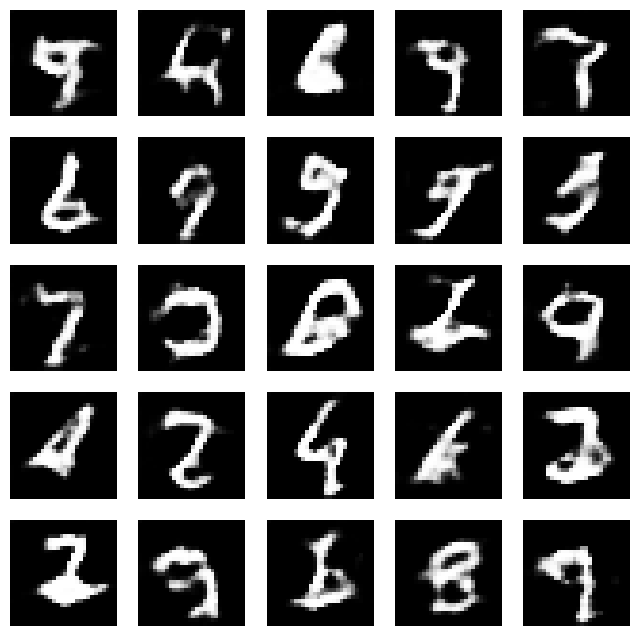

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6387 - g_loss: 0.8138
Epoch 19/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6408 - g_loss: 0.8118

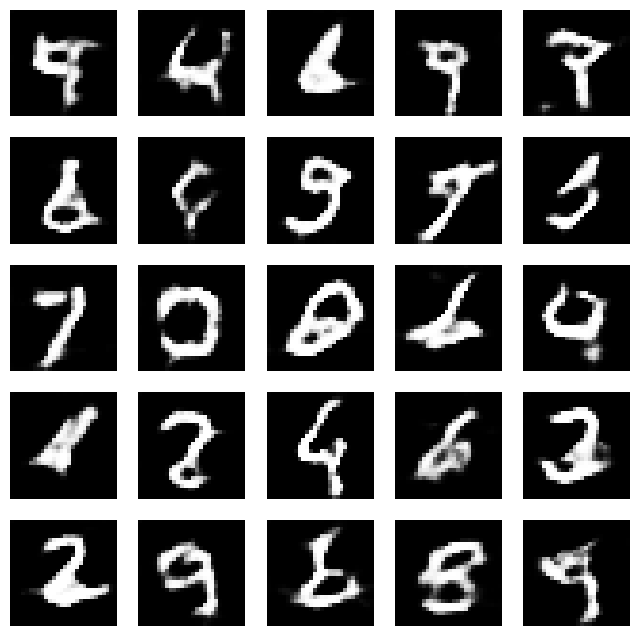

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6410 - g_loss: 0.8111
Epoch 20/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6380 - g_loss: 0.8014

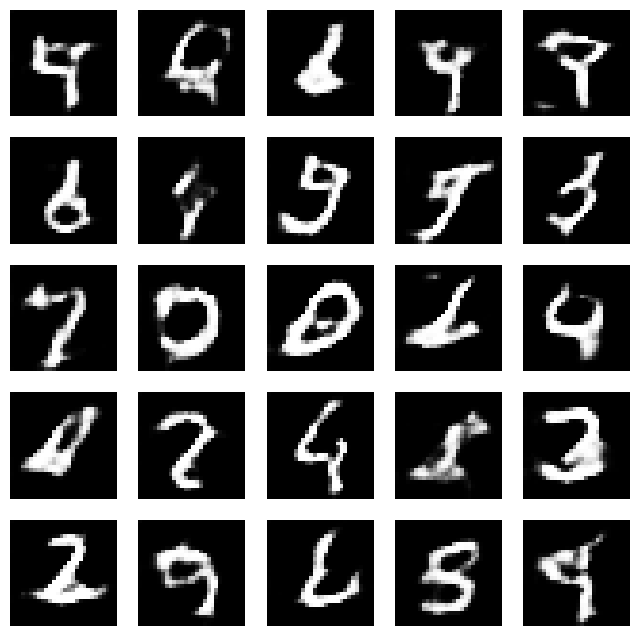

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6380 - g_loss: 0.8018
Epoch 21/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6402 - g_loss: 0.8361

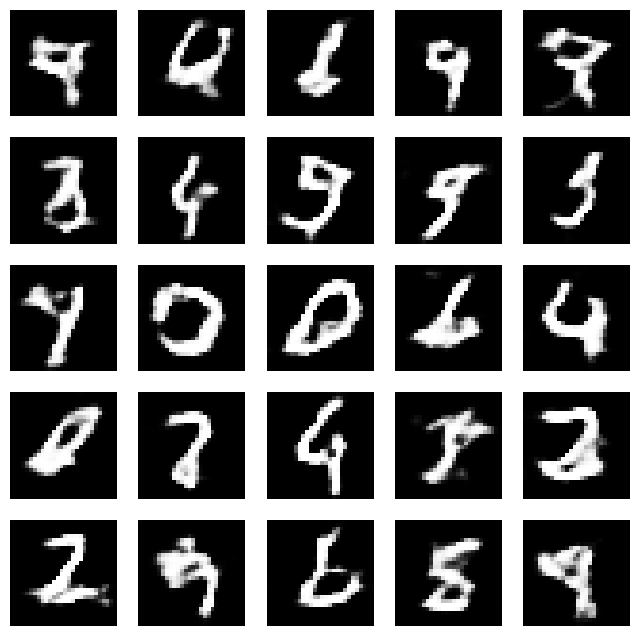

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6401 - g_loss: 0.8363
Epoch 22/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6328 - g_loss: 0.8241

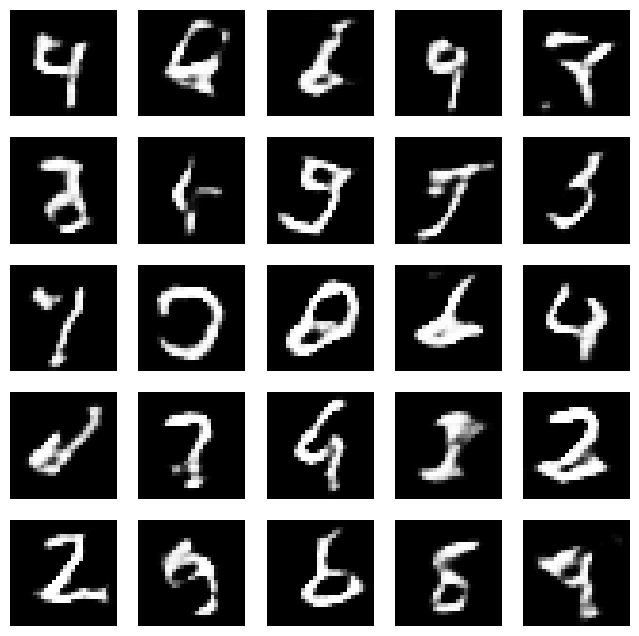

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6330 - g_loss: 0.8238
Epoch 23/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6314 - g_loss: 0.8398

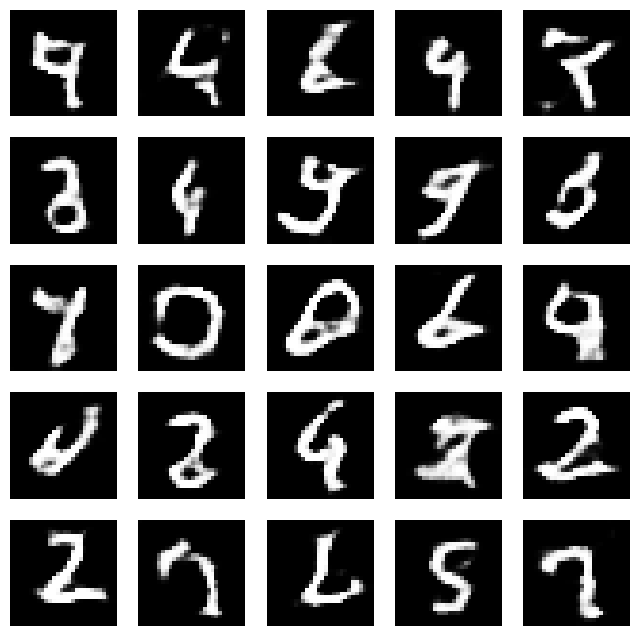

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6317 - g_loss: 0.8408
Epoch 24/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6378 - g_loss: 0.8336

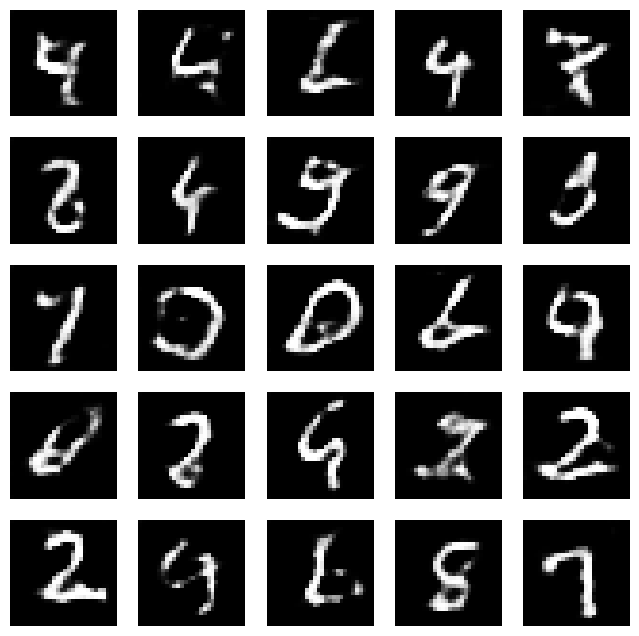

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6382 - g_loss: 0.8334
Epoch 25/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6351 - g_loss: 0.8541

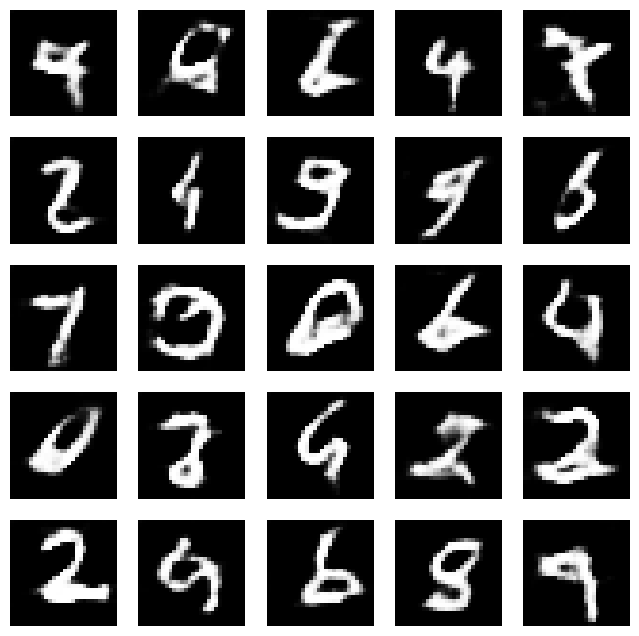

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6348 - g_loss: 0.8544
Epoch 26/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6312 - g_loss: 0.8359

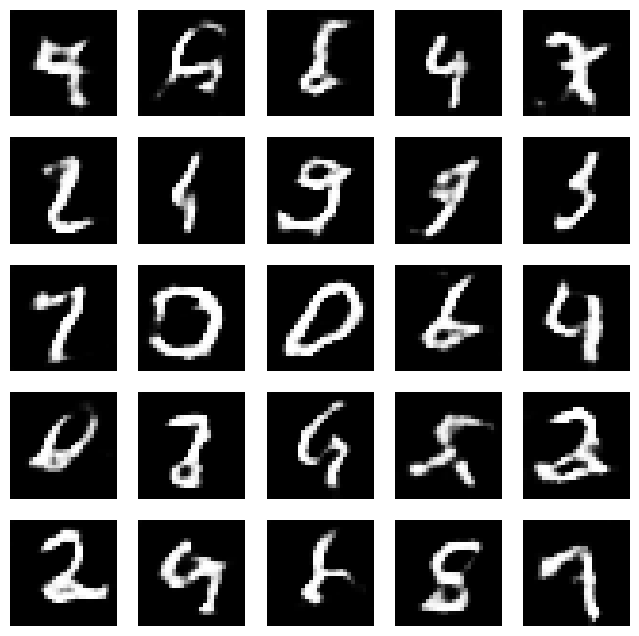

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6312 - g_loss: 0.8359
Epoch 27/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6249 - g_loss: 0.8495

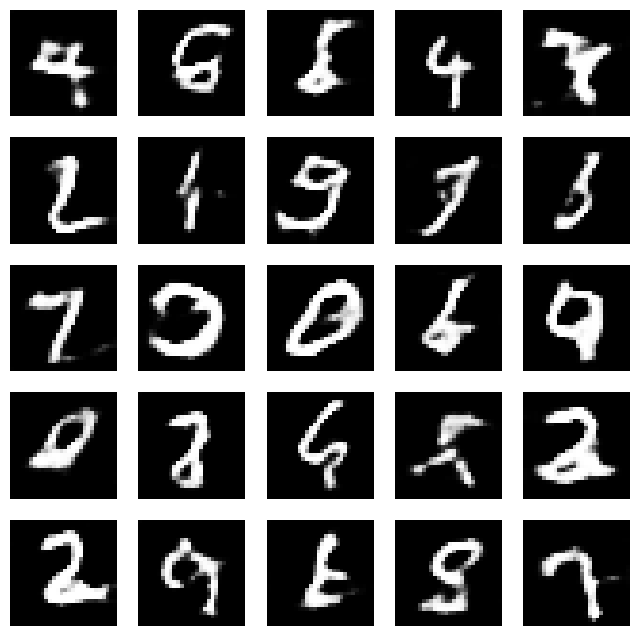

188/188 [==============================] - 4s 23ms/step - d_loss: 0.6252 - g_loss: 0.8487
Epoch 28/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6287 - g_loss: 0.8495

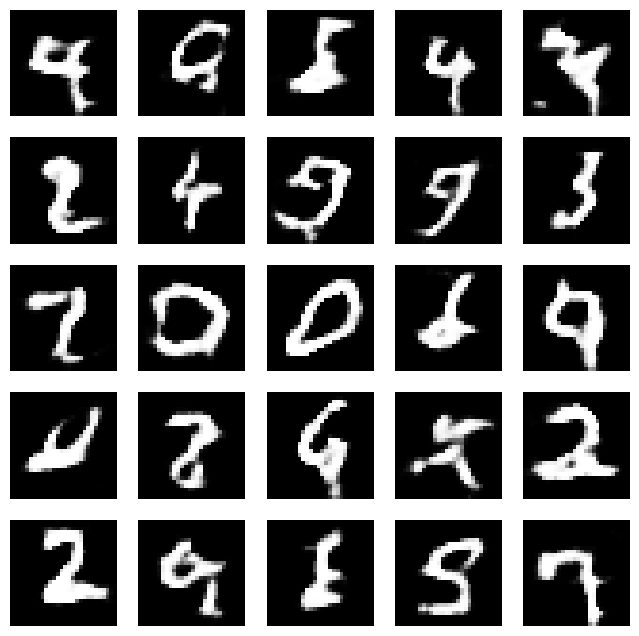

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6287 - g_loss: 0.8495
Epoch 29/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.6239 - g_loss: 0.8651

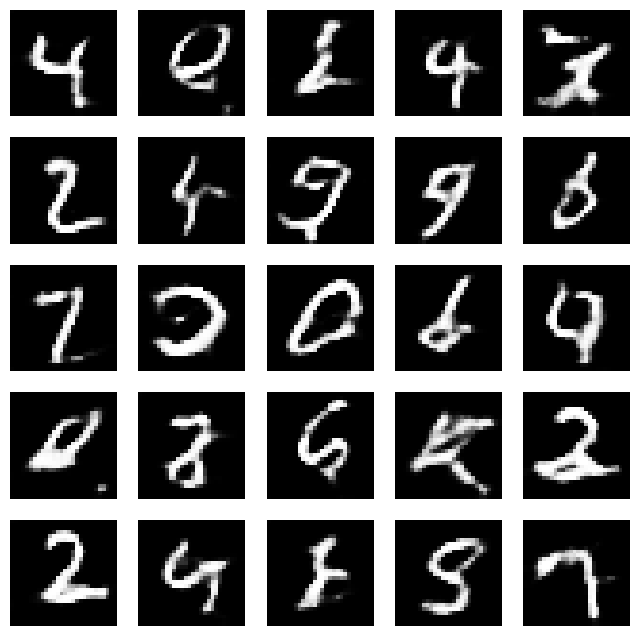

188/188 [==============================] - 4s 21ms/step - d_loss: 0.6237 - g_loss: 0.8647
Epoch 30/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6236 - g_loss: 0.8805

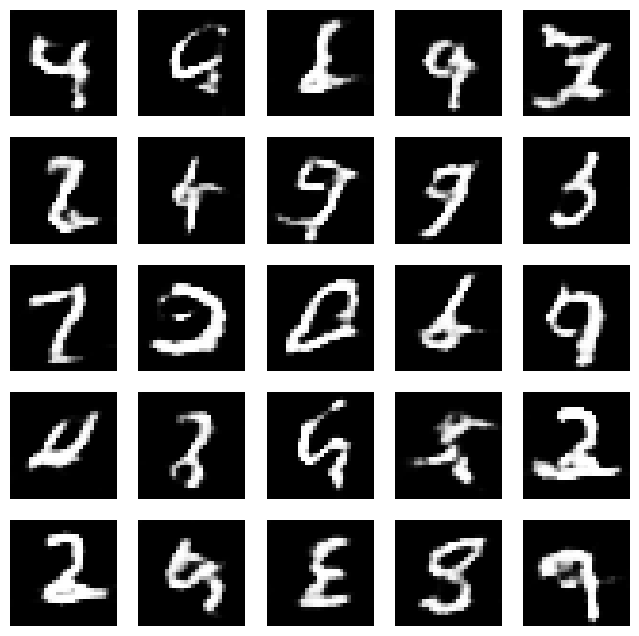

188/188 [==============================] - 4s 21ms/step - d_loss: 0.6234 - g_loss: 0.8795
Epoch 31/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6161 - g_loss: 0.8844

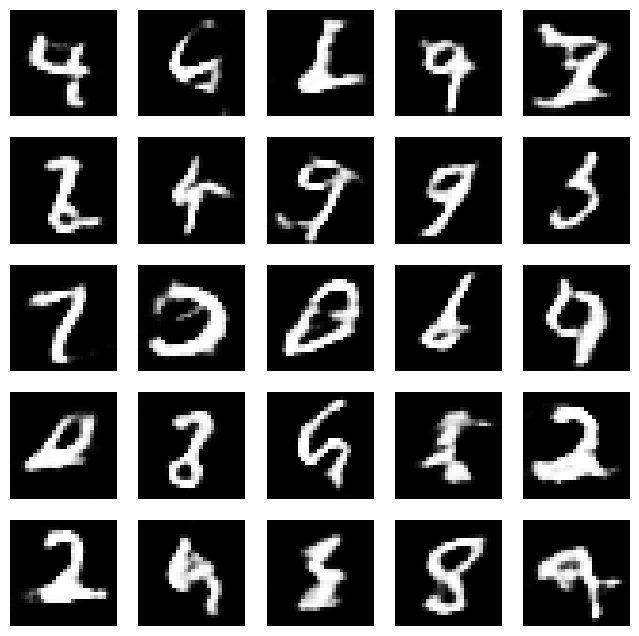

188/188 [==============================] - 5s 25ms/step - d_loss: 0.6161 - g_loss: 0.8844
Epoch 32/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6158 - g_loss: 0.9164

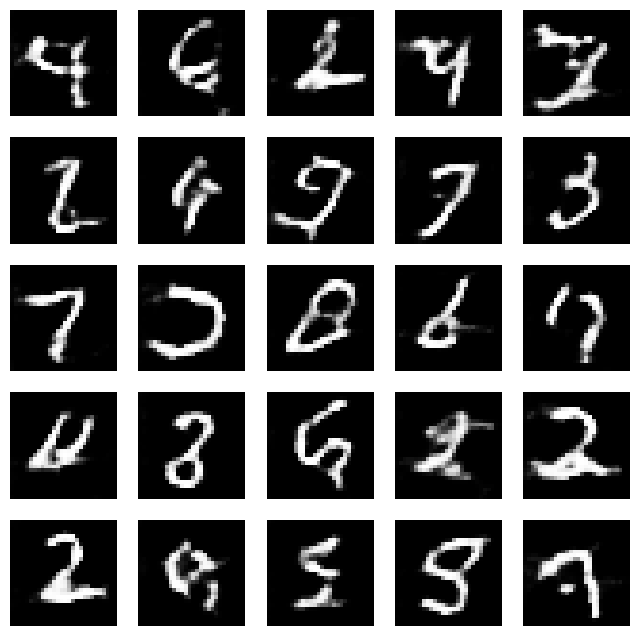

188/188 [==============================] - 4s 21ms/step - d_loss: 0.6158 - g_loss: 0.9164
Epoch 33/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6063 - g_loss: 0.8865

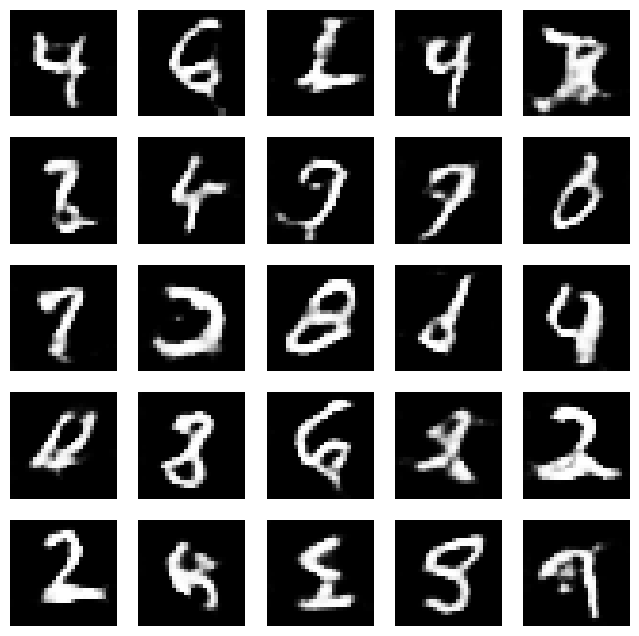

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6065 - g_loss: 0.8870
Epoch 34/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6066 - g_loss: 0.9215

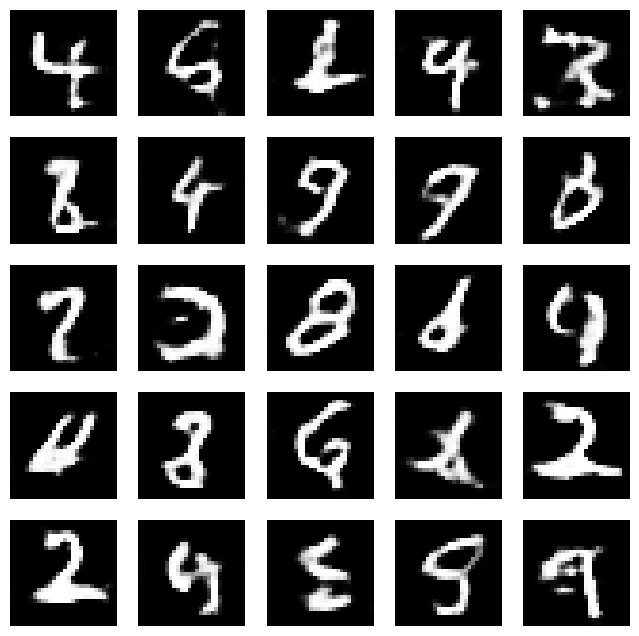

188/188 [==============================] - 5s 25ms/step - d_loss: 0.6073 - g_loss: 0.9214
Epoch 35/50
188/188 [==============================] - ETA: 0s - d_loss: 0.6067 - g_loss: 0.9076

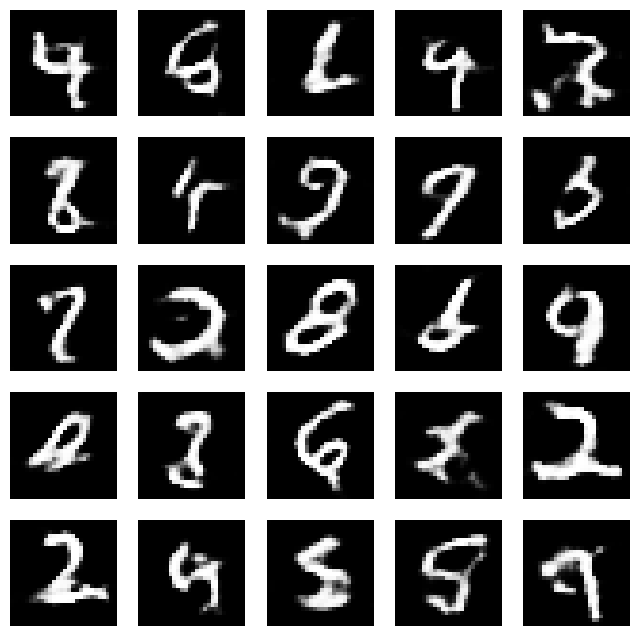

188/188 [==============================] - 4s 21ms/step - d_loss: 0.6067 - g_loss: 0.9076
Epoch 36/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6033 - g_loss: 0.9206

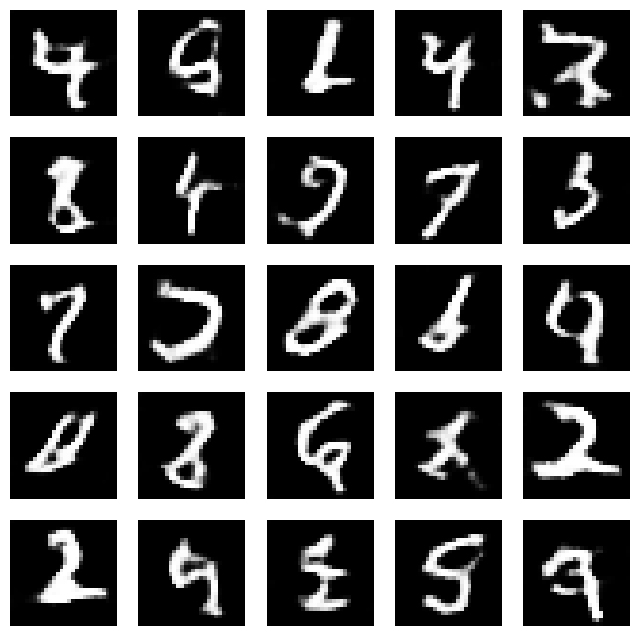

188/188 [==============================] - 4s 22ms/step - d_loss: 0.6035 - g_loss: 0.9190
Epoch 37/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.6040 - g_loss: 0.9508

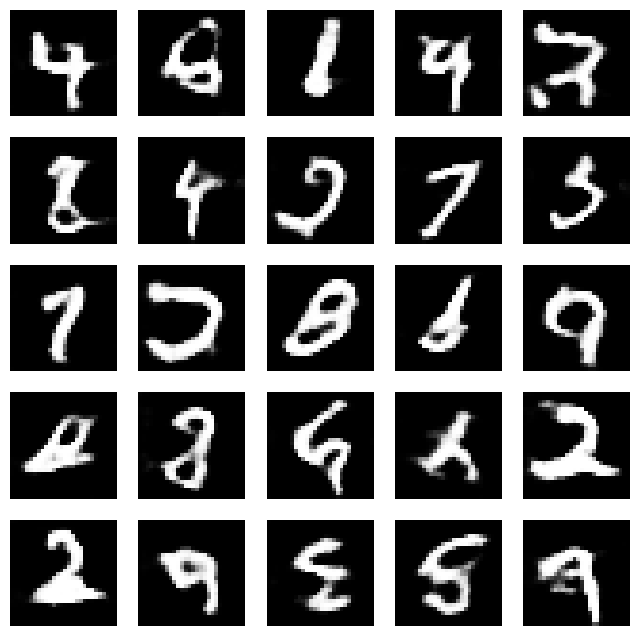

188/188 [==============================] - 5s 25ms/step - d_loss: 0.6033 - g_loss: 0.9515
Epoch 38/50
188/188 [==============================] - ETA: 0s - d_loss: 0.5968 - g_loss: 0.9390

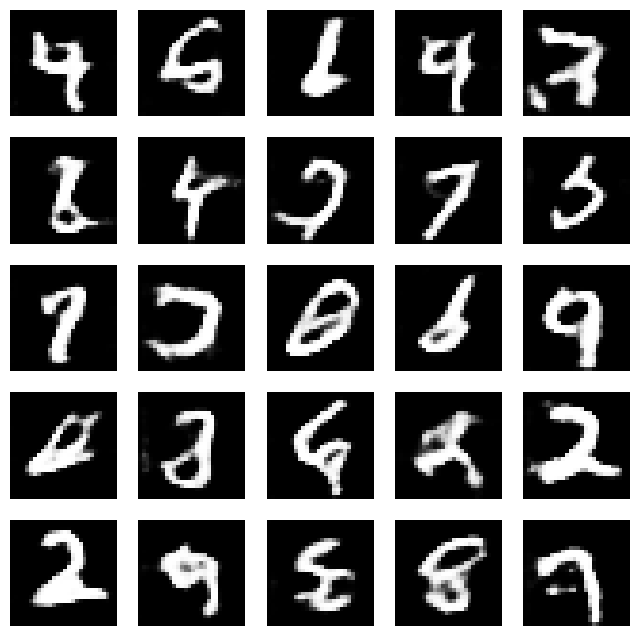

188/188 [==============================] - 4s 22ms/step - d_loss: 0.5968 - g_loss: 0.9390
Epoch 39/50
185/188 [============================>.] - ETA: 0s - d_loss: 0.5980 - g_loss: 0.9617

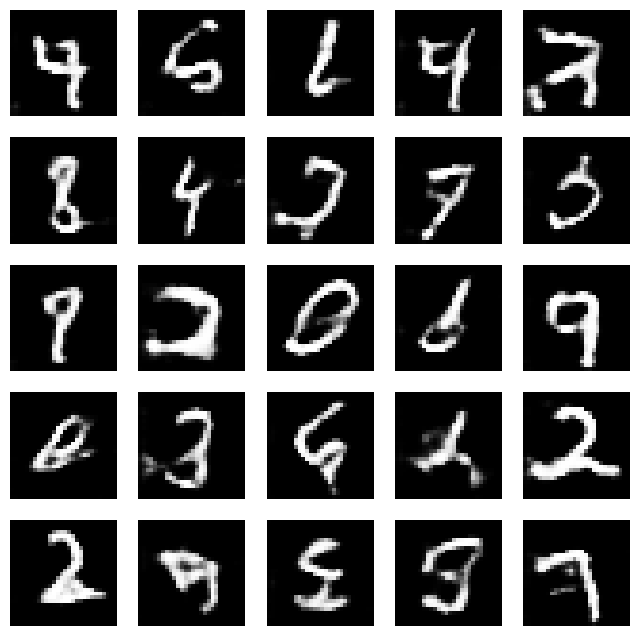

188/188 [==============================] - 4s 21ms/step - d_loss: 0.5977 - g_loss: 0.9616
Epoch 40/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.5956 - g_loss: 0.9584

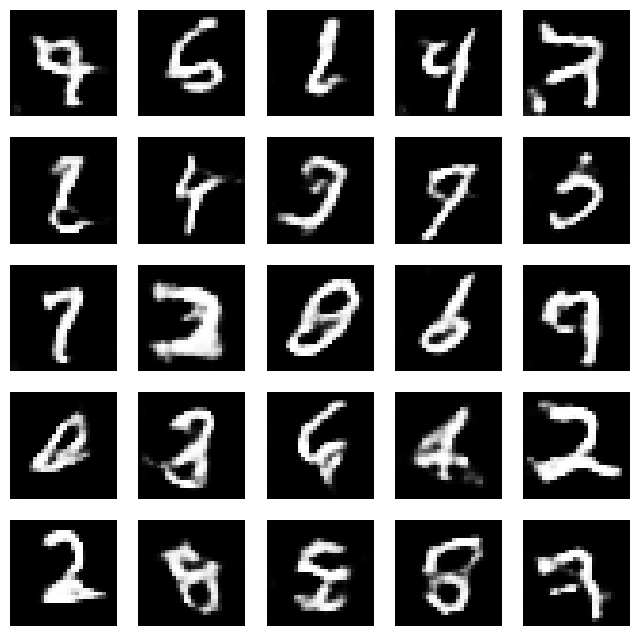

188/188 [==============================] - 4s 23ms/step - d_loss: 0.5957 - g_loss: 0.9571
Epoch 41/50
188/188 [==============================] - ETA: 0s - d_loss: 0.5872 - g_loss: 0.9509

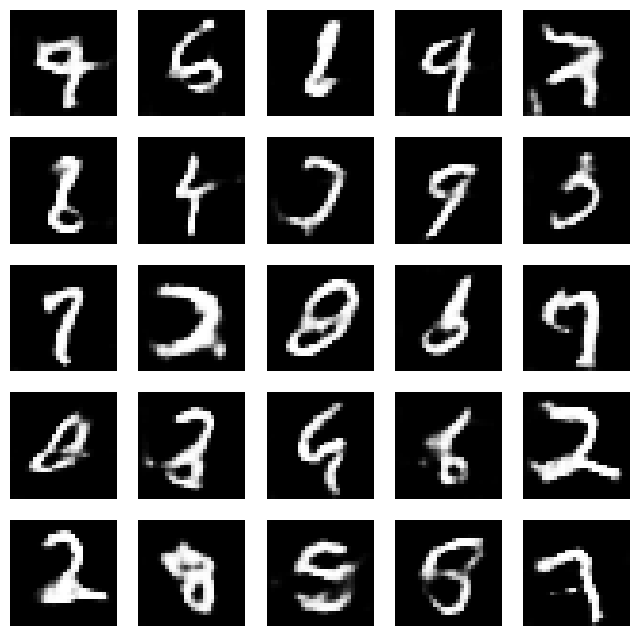

188/188 [==============================] - 4s 23ms/step - d_loss: 0.5872 - g_loss: 0.9509
Epoch 42/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.5949 - g_loss: 0.9485

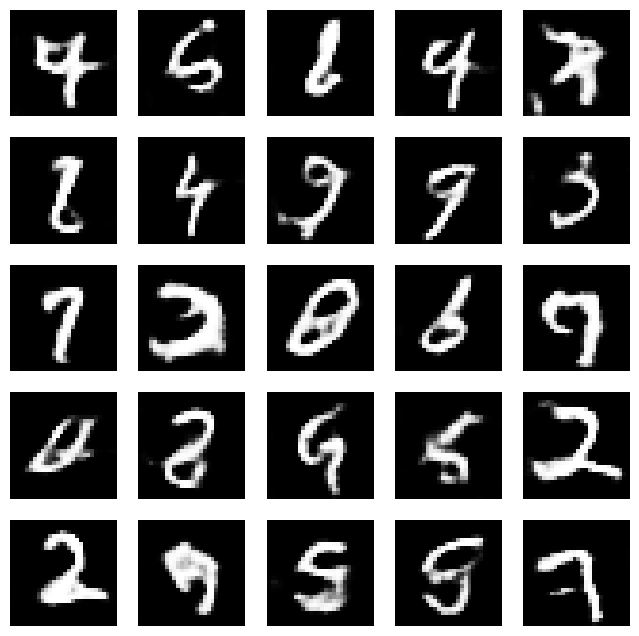

188/188 [==============================] - 4s 21ms/step - d_loss: 0.5946 - g_loss: 0.9488
Epoch 43/50
188/188 [==============================] - ETA: 0s - d_loss: 0.5936 - g_loss: 0.9470

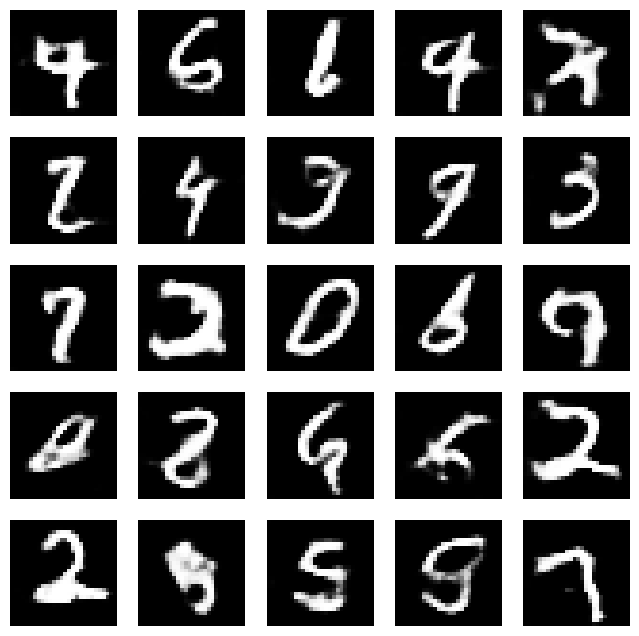

188/188 [==============================] - 4s 23ms/step - d_loss: 0.5936 - g_loss: 0.9470
Epoch 44/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.5929 - g_loss: 0.9654

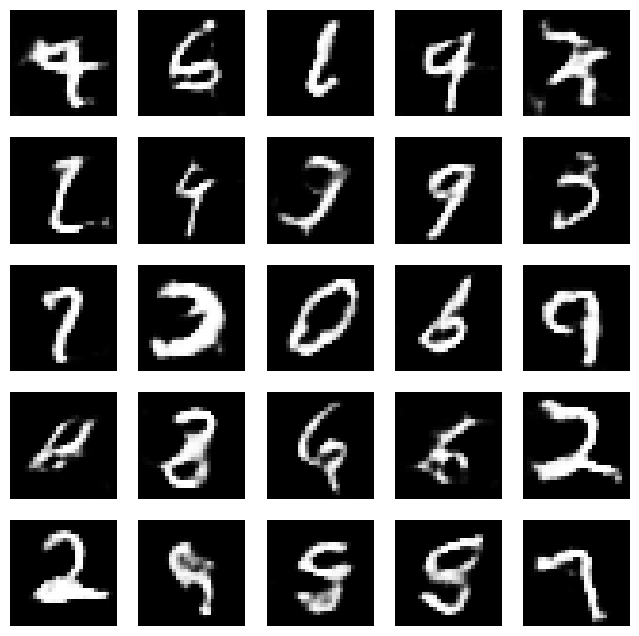

188/188 [==============================] - 4s 23ms/step - d_loss: 0.5928 - g_loss: 0.9662
Epoch 45/50
186/188 [============================>.] - ETA: 0s - d_loss: 0.5871 - g_loss: 0.9810

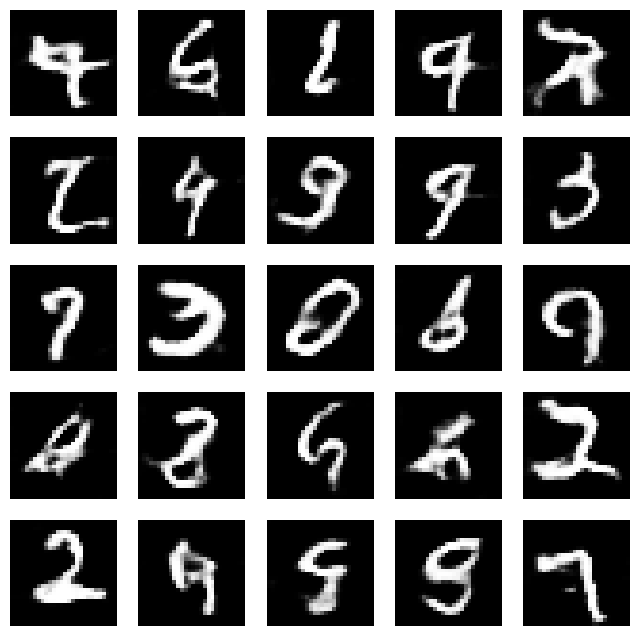

188/188 [==============================] - 4s 23ms/step - d_loss: 0.5868 - g_loss: 0.9816
Epoch 46/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.5943 - g_loss: 0.9667

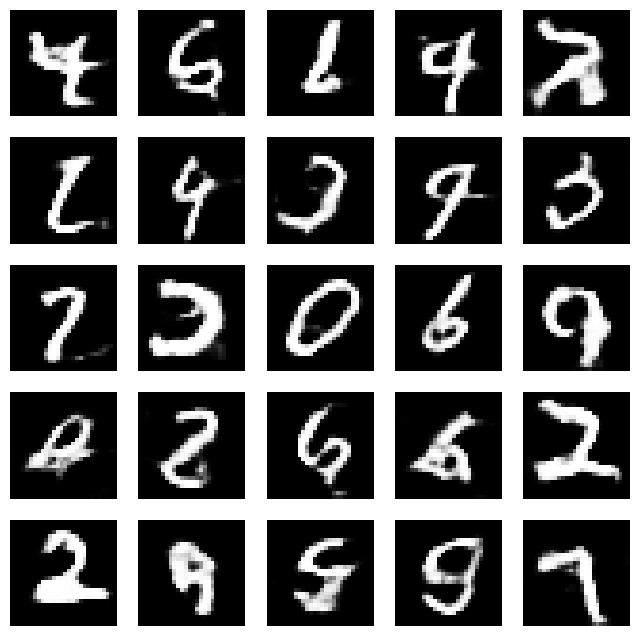

188/188 [==============================] - 4s 23ms/step - d_loss: 0.5946 - g_loss: 0.9661
Epoch 47/50
188/188 [==============================] - ETA: 0s - d_loss: 0.5903 - g_loss: 0.9652

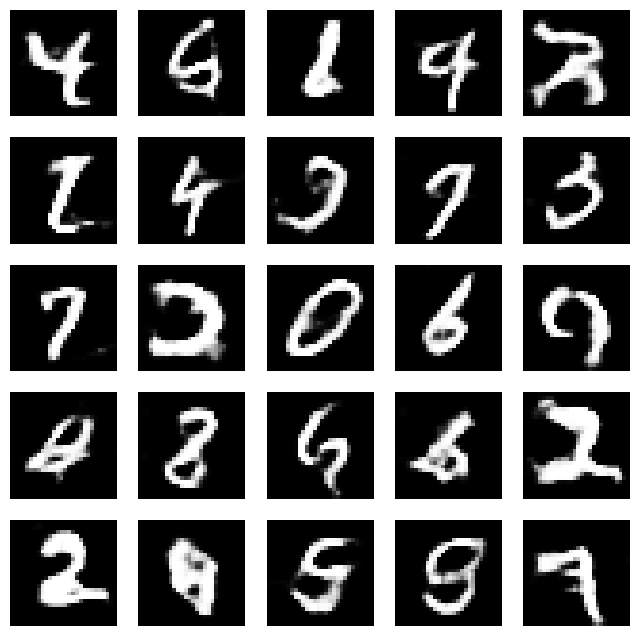

188/188 [==============================] - 4s 23ms/step - d_loss: 0.5903 - g_loss: 0.9652
Epoch 48/50
188/188 [==============================] - ETA: 0s - d_loss: 0.5903 - g_loss: 0.9725

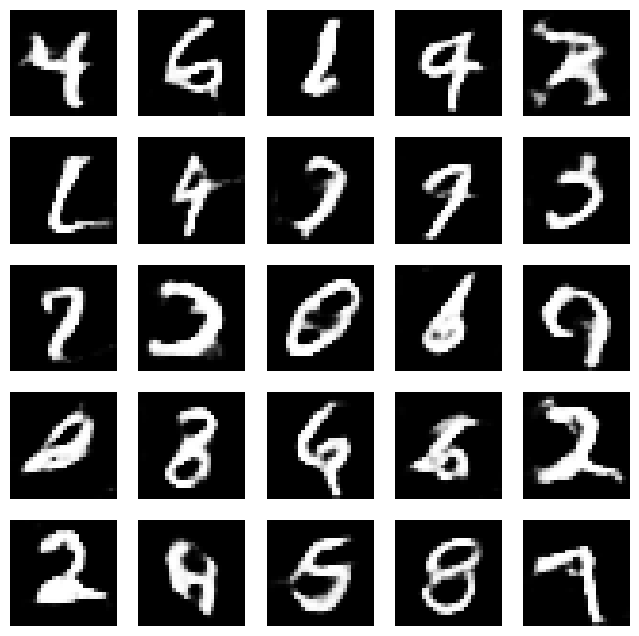

188/188 [==============================] - 4s 22ms/step - d_loss: 0.5903 - g_loss: 0.9725
Epoch 49/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.5849 - g_loss: 0.9786

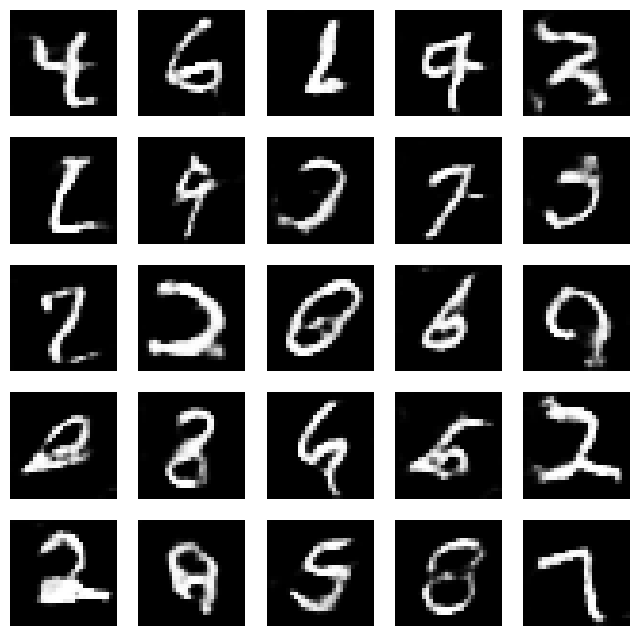

188/188 [==============================] - 4s 23ms/step - d_loss: 0.5854 - g_loss: 0.9790
Epoch 50/50
187/188 [============================>.] - ETA: 0s - d_loss: 0.5900 - g_loss: 0.9626

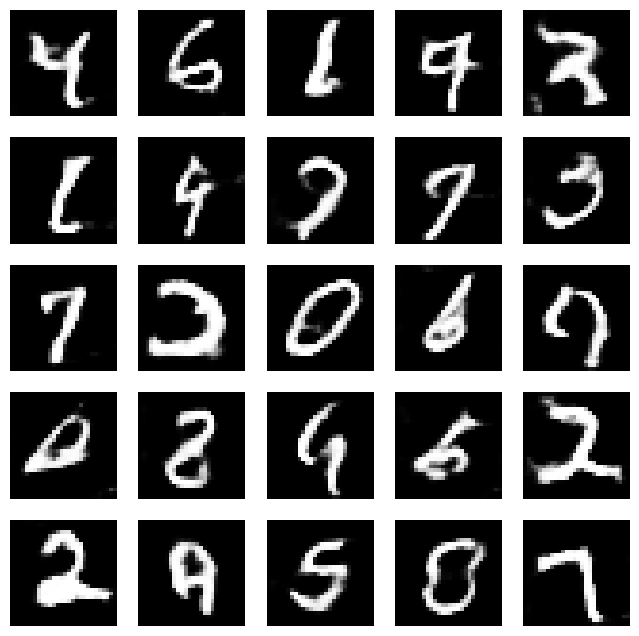

188/188 [==============================] - 4s 23ms/step - d_loss: 0.5901 - g_loss: 0.9637


In [ ]:
# setting initial parameter values and then applying optimizers while compiling
dcgan = DCGAN(generator=generator, discriminator=discriminator, num=num)
D_LR = 0.0001
G_LR = 0.0003
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())
N_EPOCHS = 50
dcgan.fit(x_train[:6000], epochs=N_EPOCHS, callbacks=[DCGANMonitor()])